# Running and analysing experiments (HFD5)

In this tutorial, you learn how to perform an experiment and then access the recorded HDF5 data to analyse it. [Another version](running_an_experiment_no_hdf5.html) perform the same experiment and analysis without saving to HFD5 and then loading from HDF5.

[This other tutorial](playback.html) showcases an alternative to access the recorded data through a [Python class ](../reference/sim/python/recorded_experiment.html#navground.sim.RecordedExperiment) that mimics the interface exposed by [Experiment](../reference/sim/python/experiment.html#navground.sim.Experiment).

## Configuring an experiment

You can look at an experiment as a machine that produces data from a configuration, which defines the simulation we want to perform, how many runs of it, which data to collect, and where to save it.

The experiment can be configured through the API or from YAML.
Let's go for YAML: we configure an experiment where 10 agents perform about 3 hours of navigation in the [Cross scenario](../reference/sim/python/scenarios/cross.html).

In [1]:
from navground import sim

yaml = """
steps: 100000
time_step: 0.1
record_world: true
record_safety_violation: true
record_task_events: true
record_pose: true
runs: 2
save_directory: .
scenario:
  type: Cross
  radius: 5
  side: 5
  agent_margin: 0.3
  add_safety_to_agent_margin: true
  tolerance: 0.2
  position_noise: 0.2
  groups:
    - number: 10
      control_period: 0.1
      behavior:
        type: ORCA
        safety_margin: 0.25
      radius: 0.1
      kinematics:
        type: Omni
        max_speed: 1.0
        max_angular_speed: 3.0
      state_estimation:
        type: Bounded
        range: 2.0
"""

We have specified to save the data in the current directory by adding
`save_directory: .`; leaving this line out would avoid that the experiment saves data to HDF5.

## Running the experiment

Running the experiment in this notebook, using the Python API

In [2]:
experiment = sim.load_experiment(yaml)
experiment.run()

is equivalent to executing
```
navground_py run <yaml_file>
```
from the command line after storing the configuration in a YAML file. 


As all the components of this experiment (scenario, behavior, kinematics, state estimation, and task) are implemented in C++, we could run it using the C++ executable too:
```
navground run <yaml_file>
```

The experiment takes some time to execute

In [3]:
experiment.duration.total_seconds()

1.982798

and saves the results to an H5DF file

In [4]:
experiment.path

PosixPath('experiment_5831055568205894653_2025-02-28_10-12-20/data.h5')

## Analysing the data 

We can load the HDF5 file using ``h5py``. 
In case you need, install it with 
```
pip install h5py
```

In [5]:
import h5py

data = h5py.File(experiment.path)

The file stores some metadata about the experiment

In [6]:
data.attrs.keys()

<KeysViewHDF5 ['begin_time', 'duration_ns', 'experiment']>

like the duration: let's check that it reports the same duration as above 

In [7]:
duration = data.attrs.get('duration_ns') / 1e9
duration

1.982798916

The metadata contains the YAML dump of the experiment itself. This way, users can reload and potentially rerun the same experiment.

In [8]:
recorded_yaml = data.attrs.get('experiment')
recorded_experiment = sim.load_experiment(recorded_yaml)

Each run is recorded in a separate HDF5 group. Let's list them

In [9]:
data.keys()

<KeysViewHDF5 ['run_0', 'run_1']>

and load the first one

In [10]:
run = data['run_0']

Runs contain some metadata too

In [11]:
run.attrs.keys()

<KeysViewHDF5 ['duration_ns', 'final_sim_time', 'maximal_steps', 'seed', 'steps', 'time_step', 'world']>

The duration of a run includes only the time required to perform the simulation, not initializing it or saving the data.

In [12]:
run.attrs.get('duration_ns') / 1e9

0.976562541

Other attributes includes the seed

In [13]:
run.attrs['seed']

0

and the number of steps performed

In [14]:
run.attrs['steps']

100000

The run also stores a YAML representation of the world at the begin of the simulation, which we can load

In [15]:
wold_yaml = run.attrs.get('world')
world = sim.load_world(wold_yaml)

and display

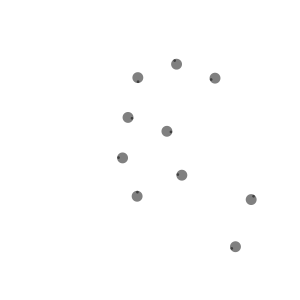

In [16]:
from IPython.display import SVG
import numpy as np
from matplotlib import pyplot as plt
from navground.sim.ui import svg_for_world

SVG(svg_for_world(world, width=300))

The actual data collected during the run is saved in HDF5 datasets

In [17]:
run.keys()

<KeysViewHDF5 ['poses', 'safety_violations', 'task_events']>

Let's plot the trajectories off all agents: first agent in blue, others in gray.

In [18]:
run['poses']

<HDF5 dataset "poses": shape (100000, 10, 3), type "<f4">

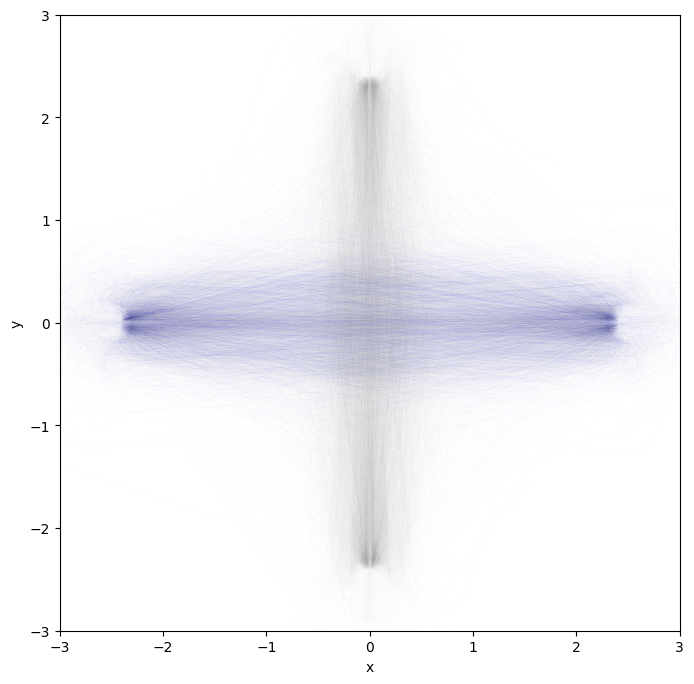

In [19]:
plt.figure(figsize=(8, 8))

ps = run['poses']

for n in range(ps.shape[1]):
    color = 'k' if n else 'b'
    alpha = 0.1 if n else 0.5
    plt.plot(ps[:, n, 0], ps[:, n, 1], '-', color=color, alpha=alpha, linewidth=0.01)

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-3, 3)
plt.ylim(-3, 3);

They were indeed doing a crossing pattern.

Let's plot how much the safety margin was violed.

In [20]:
svs = np.asarray(run['safety_violations']).flatten()

In [21]:
f = np.count_nonzero(svs) / len(svs)
print(f'Safety margin was violated {f:.1%} of the time')

Safety margin was violated 9.8% of the time


Most violation should be small. Let's check this by plotting their distribution.

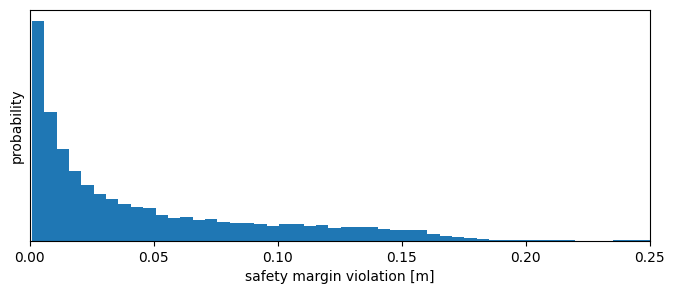

In [22]:
plt.figure(figsize=(8, 3))
plt.hist(svs, density=True, bins=np.linspace(1e-3, 0.25, 51))
plt.xlabel('safety margin violation [m]')
plt.ylabel('probability')
plt.xlim(0, 0.25)
plt.tick_params(left = False, labelleft = False);

In [23]:
np.quantile(svs, 0.999)

0.1724407125115411

We look also at event logged by the agents' tasks.

In [24]:
list(data['run_0'])

['poses', 'safety_violations', 'task_events']

In [25]:
ts = data['run_0']['task_events']

In [26]:
ts.keys()

<KeysViewHDF5 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']>

For each agents, their [WaypointsTask](../reference/sim/python/tasks/waypoints.html#navground.sim.tasks.WaypointsTask.log_size) tells us when it started moving towards which waypoint as a list ``[time, target_x, target_y, target_theta]``. Let's check the first few events for the first agent.

In [27]:
task_events, *_ = ts.values()
# time, x, y, theta
np.asarray(task_events[:2]).tolist()

[[0.0, 1.0, 2.5, 0.0], [2.499999761581421, 1.0, -2.5, -0.0]]

We collect the duration to reach waypoints, ignoring the first because agents started from radom positions.  

In [28]:
dts = []

for task in ts.values():
    for (start, *_), (end, *_) in zip(task[1:], task[2:]):
        duration = end - start
        dts.append(duration)

print(f'The time to reach a waypoint ranges betweeen {min(dts):.2f} and {max(dts):.2f} seconds,\n'
      'and 99% of the time between '
      f'{np.quantile(dts, 0.005):.2f} and {np.quantile(dts, 0.995):.2f} seconds') 

The time to reach a waypoint ranges betweeen 4.88 and 36.84 seconds,
and 99% of the time between 4.90 and 16.03 seconds


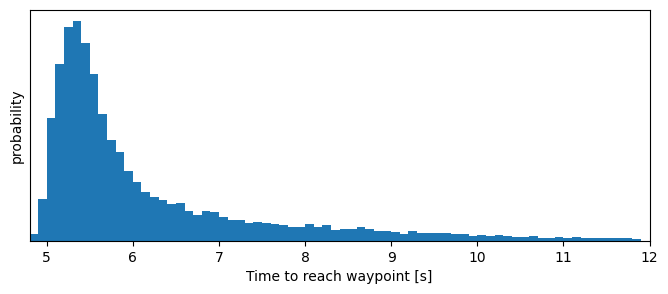

In [29]:
plt.figure(figsize=(8, 3))
plt.hist(dts, density=True, bins=np.arange(4.8, 12, 0.1))
plt.xlabel('Time to reach waypoint [s]')
plt.xlim(4.8, 12)
plt.ylabel('probability')
plt.tick_params(left = False, labelleft = False);

## Parallelize the execution

We can distribute the execution of an experiment over multiple threads or multiple processes. See the 
[guide on how to parallelize](../guides/parallelize.html) for more information.

Let's run a larger experiment (20 vs 2 runs) but using 4 processes instead of 1. We will also display the progresses using tqdm.

By passing `keep=False`, the experiment will not retrive the runs performed in the dfferent processes but save them in different HDF5 files.

In [30]:
from tqdm.notebook import tqdm

processes = 4
runs = 20
# remove the previous runs
experiment.remove_all_runs()
with tqdm(total=runs) as bar:
    experiment.run_mp(number_of_processes=processes, 
                      number_of_runs=runs, bar=bar, keep=False)

print(f"Performed {runs} runs in "
      f"{experiment.duration.total_seconds()} seconds "
      f"over {processes} processes ")

  0%|          | 0/20 [00:00<?, ?it/s]

Performed 20 runs in 10.556151 seconds over 4 processes 


As before, the results are stored in `experiment.path`

In [31]:
experiment.path

PosixPath('experiment_5831055568205894653_2025-02-28_10-12-25/data.h5')

We find other HDF5 files stored alongside:

In [32]:
sorted([p.name for p in experiment.path.parent.glob("*.h5")])

['data.h5', 'data_0.h5', 'data_1.h5', 'data_2.h5', 'data_3.h5']

In fact, by parallelizing 20 runs over 4 processes, we have effectively split the experiment in 4 sub-experiments of 5 runs each:

In [33]:
with h5py.File(experiment.path.parent/ 'data_0.h5') as f:
    print(list(f))

['run_0', 'run_1', 'run_2', 'run_3', 'run_4']


The main file ``data.h5`` contains runs *linked* to these files

In [34]:
with h5py.File(experiment.path) as f:
    print(list(f))

['run_0', 'run_1', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']


which we can access as usual, for example to compute the overall statistics of safety violations:

In [35]:
with h5py.File(experiment.path) as f:
    svs = np.concatenate([run['safety_violations'] 
                          for _, run in f.items()]).flatten()

In [36]:
f = np.count_nonzero(svs) / len(svs)
print(f'Safety margin was violated {f:.1%} of the time')

Safety margin was violated 9.8% of the time


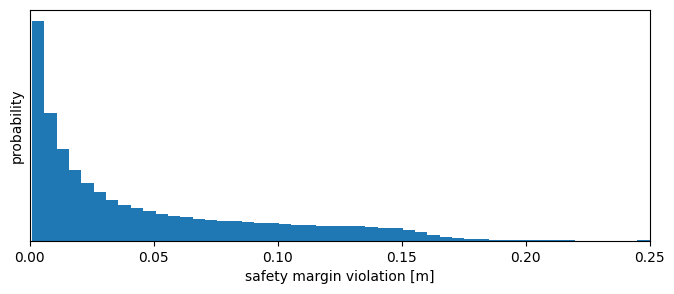

In [37]:
plt.figure(figsize=(8, 3))
plt.hist(svs, density=True, bins=np.linspace(1e-3, 0.25, 51))
plt.xlabel('safety margin violation [m]')
plt.ylabel('probability')
plt.xlim(0, 0.25)
plt.tick_params(left = False, labelleft = False);